In [1]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import statsmodels.api as sm


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
# Data splitting

# # Data imputation (NOG OP VERKEERDE PLEK) --> niet meer nodig
# split_X_train[split_X_train == 1] = np.nan
# split_X_train[split_X_train == 0.0] = np.nan

# for column in split_X_train:
#     print(column)
#     print(split_X_train[column].isnull().sum(axis = 0))

# Data loading
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

from sklearn.model_selection import train_test_split
cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)
from sklearn.feature_selection import f_regression

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')
    
    #apply preprocessing
    #X_train_pca = data_preprocessing(X_train, y_train)
    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
  
    result = stepwise_selection(X_train, y_train)

    print('resulting features:')
    print(result)
    print(f'Number of resulting features {len(result)}')
    #print(X_train)

The number of samples: 113
The number of features: 159
Add  tf_GLRLM_RunEntropy            with p-value 8.01393e-07
Add  tf_Gabor_0.2A0.0min            with p-value 0.00405312
resulting features:
['tf_GLRLM_RunEntropy', 'tf_Gabor_0.2A0.0min']
Number of resulting features 2
Add  tf_GLRLM_RunEntropy            with p-value 1.22997e-08
Add  tf_Gabor_0.2A1.57skew          with p-value 0.00389678
resulting features:
['tf_GLRLM_RunEntropy', 'tf_Gabor_0.2A1.57skew']
Number of resulting features 2
Add  tf_GLRLM_RunEntropy            with p-value 3.65698e-07
Add  sf_evar_std_2D                 with p-value 0.00662625
resulting features:
['tf_GLRLM_RunEntropy', 'sf_evar_std_2D']
Number of resulting features 2
Add  tf_GLRLM_RunEntropy            with p-value 9.4905e-08
Add  tf_Gabor_0.2A0.0min            with p-value 0.00438026
resulting features:
['tf_GLRLM_RunEntropy', 'tf_Gabor_0.2A0.0min']
Number of resulting features 2


In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

knn = neighbors.KNeighborsClassifier()
parameters = {
    "n_neighbors": list(range(1, 50, 2))
}

cv_5fold = model_selection.StratifiedKFold(n_splits=5)

grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_5fold, scoring='roc_auc')


for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')
    
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)
    

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled,y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(10,'Score'))  #print 10 best features
    best_features = featureScores.nlargest(10,'Score')['Specs']
    #print(best_features)
    df_X_train_features = df_X_train_scaled[best_features]
    df_X_test_features = df_X_validation_scaled[best_features]
    
    grid_search.fit(df_X_train_features, y_train)


    print(grid_search.best_params_)


    

{'n_neighbors': 19}
{'n_neighbors': 39}
{'n_neighbors': 15}
{'n_neighbors': 39}


45      45
48      48
31      31
32      32
43      43
53      53
7        7
40      40
36      36
131    131
Name: Specs, dtype: int64
43    43
53    53
7      7
36    36
45    45
42    42
40    40
62    62
52    52
31    31
Name: Specs, dtype: int64
43      43
45      45
7        7
62      62
52      52
53      53
42      42
0        0
36      36
110    110
Name: Specs, dtype: int64
45      45
43      43
36      36
28      28
133    133
42      42
104    104
53      53
130    130
134    134
Name: Specs, dtype: int64
45      45
43      43
53      53
7        7
40      40
137    137
42      42
36      36
32      32
63      63
Name: Specs, dtype: int64
43      43
45      45
133    133
104    104
36      36
32      32
7        7
44      44
134    134
40      40
Name: Specs, dtype: int64
45    45
43    43
36    36
52    52
62    62
42    42
65    65
0      0
74    74
7      7
Name: Specs, dtype: int64
7        7
45      45
43      43
36      36
32      32
133    133
53      53
40      40


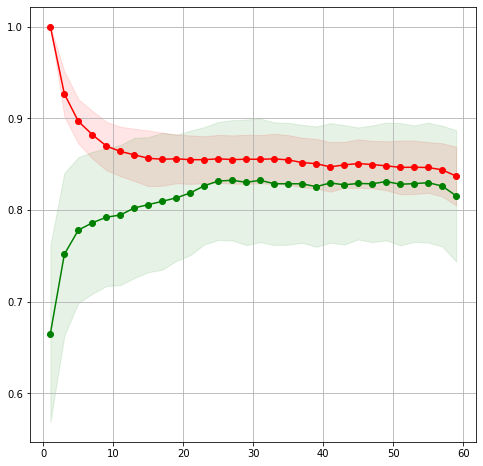

In [74]:
k_list = list(range(1, 60, 2))
all_train = []
all_test = []
for _ in range(0,20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing 
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        df_X_train_scaled = pd.DataFrame(X_train_scaled)
        X_validation_scaled = scaler.transform(X_validation)
        df_X_validation_scaled = pd.DataFrame(X_validation_scaled)
        

        bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
        fit = bestfeatures.fit(df_X_train_scaled,y_train)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']  #naming the dataframe columns
        #print(featureScores.nlargest(10,'Score'))  #print 10 best features
        best_features = featureScores.nlargest(10,'Score')['Specs']
        print(best_features)
        df_X_train_features = df_X_train_scaled[best_features]
        df_X_test_features = df_X_validation_scaled[best_features]

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(df_X_train_features, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(df_X_train_features)[:, 1]
            test_proba = clf_knn.predict_proba(df_X_test_features)[:, 1]
            
            score_train = metrics.roc_auc_score(y_train, train_proba)
            score_test = metrics.roc_auc_score(y_validation, test_proba)
            

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")

In [1]:
cv_5fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
train_all = []
test_all = []

for _ in range(5):
    for train_index, test_index in cv_5fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]


        # Data preprocessing
        scaler = preprocessing.RobustScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        df_X_train_scaled = pd.DataFrame(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        df_X_test_scaled = pd.DataFrame(X_test_scaled)
        

        bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
        fit = bestfeatures.fit(df_X_train_scaled,y_train)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
        #concat two dataframes for better visualization 
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']  #naming the dataframe columns
        #print(featureScores.nlargest(10,'Score'))  #print 10 best features
        best_features = featureScores.nlargest(10,'Score')['Specs']
        #print(best_features)
        df_X_train_features = df_X_train_scaled[best_features]
        df_X_test_features = df_X_test_scaled[best_features]

        # Classifier with hyperparameter n = 35
        clf = neighbors.KNeighborsClassifier(n_neighbors=35)
        clf_knn.fit(df_X_train_features, y_train)



        # Tests 
        train_proba = clf_knn.predict_proba(df_X_train_features)[:, 1]
        test_proba = clf_knn.predict_proba(df_X_test_features)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)


        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(test_scores_mean)
print(test_scores_std)
print('#'*80)

NameError: name 'model_selection' is not defined